In [45]:
import six
import sys
sys.modules['sklearn.externals.six'] = six

import warnings
warnings.filterwarnings('ignore')

In [46]:
import math
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from auto_ml import Predictor
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
sns.set_theme()

sns.set_style("whitegrid")

In [47]:
def generate_data(l=20):
    # generate x,y,z used for exp
    X = []
    Y = []
    Z = []
    
    for i in range(l):
        x_tmp = np.arange(0, 1*math.pi, 0.02)
        z_tmp = 3*np.sin(x_tmp)+3.5
        
        y_tmp = np.sin((0.99-i*0.01)*x_tmp)+4.5-i*0.02
        
        x_new = [tmp+i*3.14 for tmp in x_tmp]
        

        X = X + x_new
        Y = Y + y_tmp.tolist()
        Z = Z + z_tmp.tolist()
        
        #break
        
    return X,Y,Z
    

In [48]:

plt.style.use('ggplot')
import matplotlib as mpl
mpl.style.use('seaborn-whitegrid')

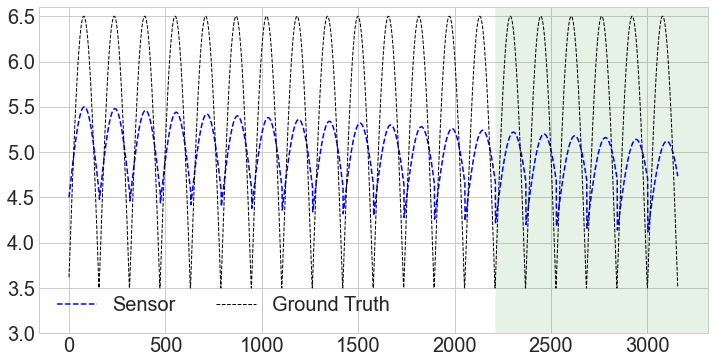

In [49]:
fig, ax = plt.subplots(figsize=(12, 6))


x,y,z = generate_data()

shift=2
x,y,z = x[:-shift],y[:-shift],z[shift:]


ax.plot(y, color='blue', label='Sensor',linestyle='dashed')
ax.plot(z, color='black', label='Ground Truth',linestyle='dashed',linewidth=1)


plt.ylim([3.0, 6.6])
plt.legend(loc="lower left", ncol = 2,fontsize=20,fancybox=True,facecolor="black",edgecolor='white')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)


someX, someY = int(len(x)*0.7), 0
currentAxis = plt.gca()
ax.add_patch(patches.Rectangle((someX, someY), int(len(x)*0.4), 7,
	alpha=0.1, facecolor='green'))

plt.savefig("figs/example.pdf", format="pdf", bbox_inches = 'tight')


In [50]:
idx = int(len(x)*0.7)
x_train = x[:idx]
x_test = x[idx:]
y_train = y[:idx]
y_test = y[idx:]
z_train = z[:idx]
z_test = z[idx:]

In [51]:
m, b = np.polyfit(y_train, z_train, 1)

In [52]:

plt.style.use('ggplot')

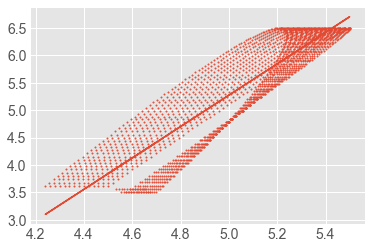

In [53]:
plt.scatter(y_train,z_train,alpha=0.9,s=2)
plt.plot(y_train, m*np.array(y_train) + b,'-')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.savefig("figs/example_scatter.pdf", format="pdf", bbox_inches = 'tight')

### LR

In [54]:
reg = LinearRegression().fit(np.array(y_train).reshape(-1,1), np.array(z_train))
y11 = reg.predict(np.array(y_test).reshape(-1,1))

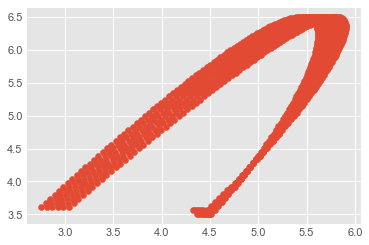

In [55]:
plt.scatter(y11,z_test)

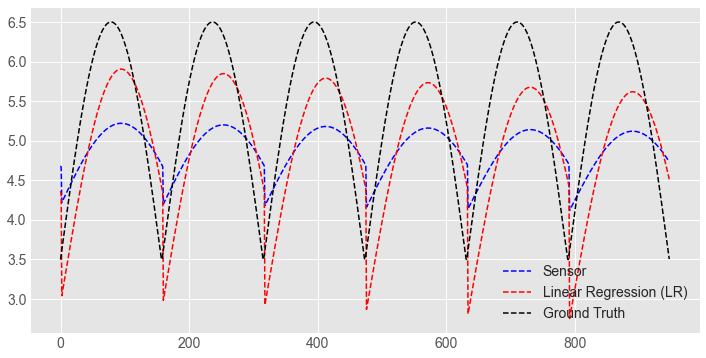

In [56]:
fig, ax = plt.subplots(figsize=(12, 6))


ax.plot(y_test, color='blue', label='Sensor',linestyle='dashed')
ax.plot(y11, color='red', label='Linear Regression (LR)',linestyle='dashed')
ax.plot(z_test, color='black', label='Ground Truth',linestyle='dashed')


plt.legend(loc='best',fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.savefig("figs/example_lr.pdf", format="pdf", bbox_inches = 'tight')

In [57]:
metrics.mean_absolute_error(z_test, y11),metrics.mean_squared_error(z_test, y11)

(0.7361549234568943, 0.65063877220881)

In [58]:
metrics.mean_absolute_error(z_test, y_test),metrics.mean_squared_error(z_test, y_test)

(0.8044631631046898, 0.8408802303508625)

In [59]:
y_df = pd.DataFrame(y,columns = ['y'])
y_df['target'] = z

In [60]:
%%capture

column_descriptions = {
    'target': 'output'
}

ml_predictor = Predictor(type_of_estimator='regressor', column_descriptions=column_descriptions)

ml_predictor.train(y_df.iloc[:idx,:])
y_rf_one = ml_predictor.predict(y_df.iloc[idx:,:])

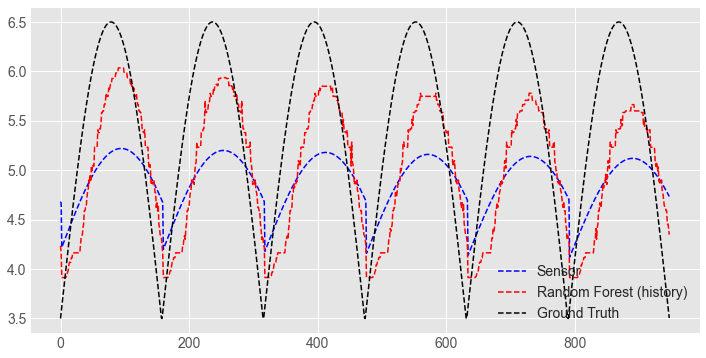

In [61]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(y_test, color='blue', label='Sensor',linestyle='dashed')
ax.plot(y_rf_one, color='red', label='Random Forest (history)',linestyle='dashed')
ax.plot(z_test, color='black', label='Ground Truth',linestyle='dashed')


plt.legend(loc='best',fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.savefig("figs/example_hist.pdf", format="pdf", bbox_inches = 'tight')

In [62]:
metrics.mean_absolute_error(z_test, y_rf_one),metrics.mean_squared_error(z_test, y_rf_one)

(0.649515016992141, 0.5701988894606639)

### use latest history

In [63]:
y_df = pd.DataFrame(y,columns = ['y'])
y_df['y-1'] = y_df['y'].shift(1)
y_df['y-2'] = y_df['y'].shift(2)
y_df = y_df.fillna(method="bfill")
y_hist = y_df.values


In [64]:
reg = LinearRegression().fit(np.array(y_hist), np.array(z))
y12 = reg.predict(np.array(y_hist))

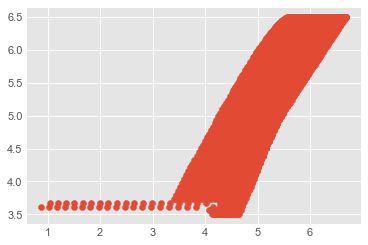

In [65]:
plt.scatter(y12,z)

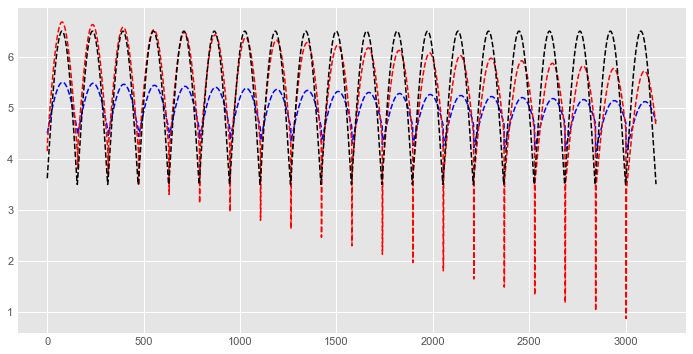

In [66]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(y, color='blue', label='Sine wave',linestyle='dashed')
ax.plot(y12, color='red', label='Sine wave',linestyle='dashed')
ax.plot(z, color='black', label='Cosine wave',linestyle='dashed')


plt.show()

In [67]:
y_df['target'] = z
y_df['d'] = abs((y_df['y']-y_df['y-2'])/0.04)
y_df.to_csv('y_hist.csv',index=False)

In [68]:
%%capture

column_descriptions = {
    'target': 'output'
}

ml_predictor = Predictor(type_of_estimator='regressor', column_descriptions=column_descriptions)

ml_predictor.train(y_df.iloc[:idx,:])
y_rf_hist = ml_predictor.predict(y_df.iloc[idx:,:])

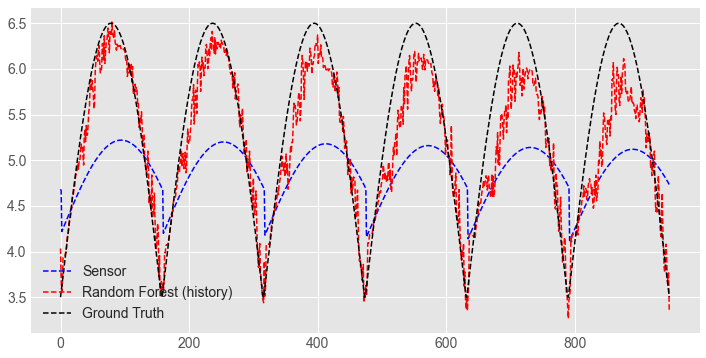

In [69]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(y_test, color='blue', label='Sensor',linestyle='dashed')
ax.plot(y_rf_hist, color='red', label='Random Forest (history)',linestyle='dashed')
ax.plot(z_test, color='black', label='Ground Truth',linestyle='dashed')


plt.legend(loc='best',fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.savefig("figs/example_hist.pdf", format="pdf", bbox_inches = 'tight')

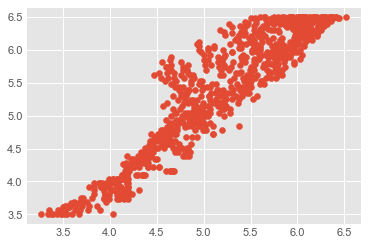

In [70]:
plt.scatter(y_rf_hist,z_test)

In [71]:
metrics.mean_absolute_error(z_test, y_rf_hist),metrics.mean_squared_error(z_test, y_rf_hist)

(0.2953231428624889, 0.15890904293016966)

In [72]:
metrics.mean_absolute_error(z, y12),metrics.mean_squared_error(z, y12)

(0.4018924977522995, 0.252197838893692)

### use hist and future

In [73]:
y_df = pd.DataFrame(y,columns = ['y'])
y_df['y-1'] = y_df['y'].shift(1)
y_df['y-2'] = y_df['y'].shift(2)
y_df['y+1'] = y_df['y'].shift(-1)
y_df['y+2'] = y_df['y'].shift(-2)
y_df = y_df.fillna(method="bfill")
y_df = y_df.fillna(method="ffill")

y_df['d1'] = abs((y_df['y']-y_df['y-2'])/0.04)
y_df['d2'] = abs((y_df['y+2']-y_df['y'])/0.04)
y_df['d'] = abs((y_df['y+2']-y_df['y-2'])/0.08)



y_all = y_df.values


In [74]:
reg = LinearRegression().fit(np.array(y_all), np.array(z))
y13 = reg.predict(np.array(y_all))

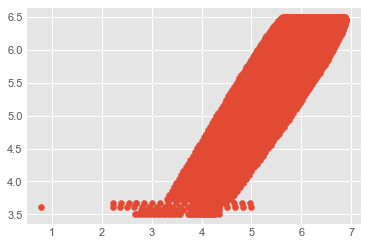

In [75]:
plt.scatter(y13,z)

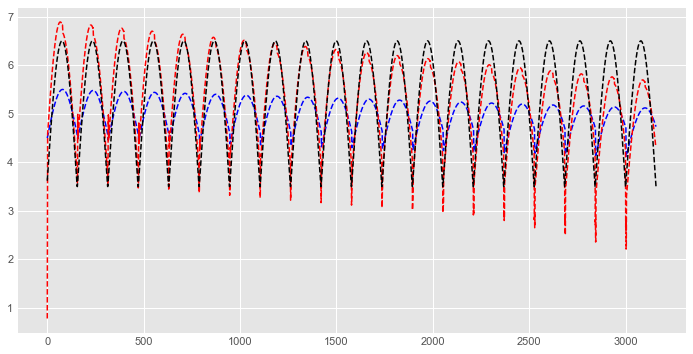

In [76]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(y, color='blue', label='Sine wave',linestyle='dashed')
ax.plot(y13, color='red', label='Sine wave',linestyle='dashed')
ax.plot(z, color='black', label='Cosine wave',linestyle='dashed')

plt.show()

In [80]:
## use auto_ml

In [81]:
y_df['target'] = z
y_df.head(2)

y_df.to_csv('y_all.csv',index=False)

In [83]:
%%capture

column_descriptions = {
    'target': 'output'
}

ml_predictor = Predictor(type_of_estimator='regressor', column_descriptions=column_descriptions)

ml_predictor.train(y_df.iloc[:idx,:])
y_rf = ml_predictor.predict(y_df.iloc[idx:,:])

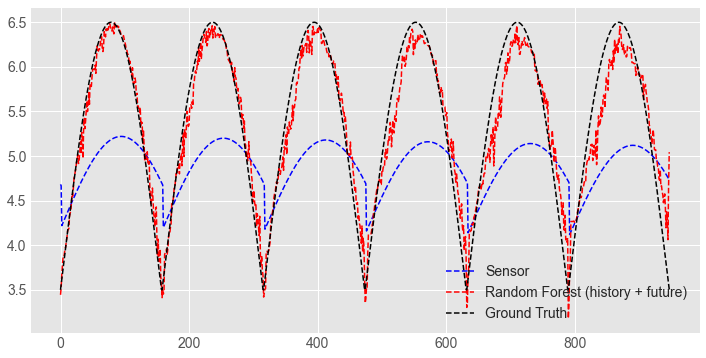

In [84]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(y_test, color='blue', label='Sensor',linestyle='dashed')
ax.plot(y_rf, color='red', label='Random Forest (history + future)',linestyle='dashed')
ax.plot(z_test, color='black', label='Ground Truth',linestyle='dashed')

plt.legend(loc='best',fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.savefig("figs/example_all.pdf", format="pdf", bbox_inches = 'tight')

In [85]:
metrics.mean_absolute_error(z_test, y_rf),metrics.mean_squared_error(z_test, y_rf)

(0.19505337432971634, 0.06560285008734658)

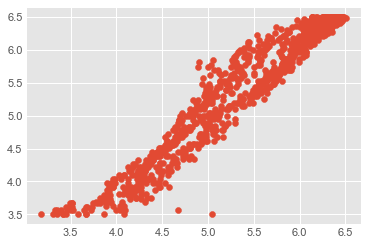

In [86]:
plt.scatter(y_rf,z_test)

In [87]:
### all results
import matplotlib as mpl
mpl.style.use('seaborn-whitegrid')

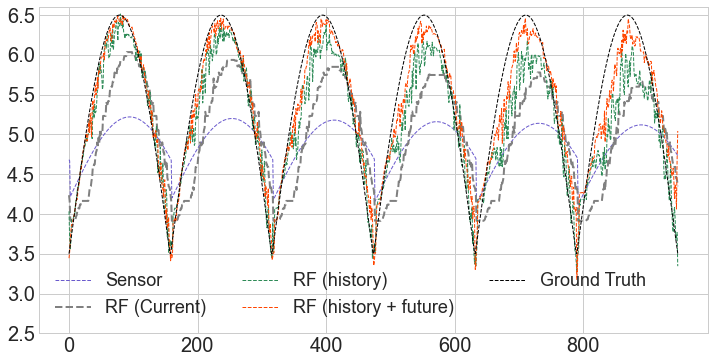

In [88]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(y_test, color='slateblue', label='Sensor',linestyle='dashed',linewidth=1)
ax.plot(y_rf_one, color='grey', label='RF (Current)',linestyle='dashed',linewidth=2)
ax.plot(y_rf_hist, color='seagreen', label='RF (history)',linestyle='dashed',linewidth=1)
ax.plot(y_rf, color='orangered', label='RF (history + future)',linestyle='dashed',linewidth=1)
ax.plot(z_test, color='black', label='Ground Truth',linestyle='dashed',linewidth=1)

plt.ylim([2.5,6.6])

plt.legend(loc='lower left',fontsize=18,ncol=3)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.savefig("figs/example_all.pdf", format="pdf", bbox_inches = 'tight')